In [1]:
# conda activate evalgemma

import argparse
import torch
import os
import json
from tqdm import tqdm
import shortuuid
import torch.nn as nn
import numpy as np
from PIL import Image
import math
from typing import Optional, Union, List, Tuple

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoProcessor 
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor


class CustomPaliGemmaForConditionalGeneration(PaliGemmaForConditionalGeneration):
    def __init__(self, config, threshold=-0.5):
        super().__init__(config)
        self.threshold = threshold
    
    def forward(
        self,
        input_ids=None,
        pixel_values=None,
        attention_mask=None,
        position_ids=None,
        past_key_values=None,
        token_type_ids=None,
        cache_position=None,
        inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        logits_to_keep=0,
        **kwargs,
    ):
        # Call the parent class's forward method
        outputs = super().forward(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            token_type_ids=token_type_ids,
            cache_position=cache_position,
            inputs_embeds=inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=True,  # Important to get hidden states for modification
            return_dict=return_dict,
            logits_to_keep=logits_to_keep,
            **kwargs,
        )

        # Modify the hidden_states before logits are computed
        hidden_states = outputs.hidden_states[-1]  # Get the last hidden state
        modified_hidden_states = self.modify_hidden_states(hidden_states)

        # Recompute logits using the modified hidden states
        # The key thing here is realizing that language_model hides the lm_head as its attribute
        logits = self.language_model.lm_head(modified_hidden_states)

        # Return the modified outputs
        outputs.logits = logits
        return outputs
    
    def modify_hidden_states(self, hidden_states):
        if self.threshold is not None:
            threshold = self.threshold
            hidden_states = torch.relu(hidden_states - threshold) + threshold
        return hidden_states


model_path = '/data/students/earl/llava-dissector/paligemma2-3b-mix-448'
model = CustomPaliGemmaForConditionalGeneration.from_pretrained(
    model_path,
    attn_implementation='eager',
    )
    #device_map='auto').eval()
processor = PaliGemmaProcessor.from_pretrained(model_path)

device = torch.device('cuda:1')
model.to(device)

/data/students/earl/anaconda3/envs/evalgemma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Language Model used: <class 'transformers.models.gemma2.modeling_gemma2.Gemma2ForCausalLM'>


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CustomPaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(1024, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_featu

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


<loc0457><loc0880><loc0528><loc0914> occluded person ; <loc0447><loc0742><loc0589><loc0801> occluded person ; <loc0457><loc0883><loc0529><loc0912> occluded person ; <loc0550><loc0232><loc0912><loc0439> occluded person ; <loc0457><loc0883><loc0529><loc0912> occluded person ; <loc0457><loc0742><loc0589><loc0788> occluded person ; <loc0331><loc0369><loc0825><loc0552> occluded person ; <loc0458><loc0883><loc0529><loc0912> occluded person ; <loc0458><loc0226><loc0490><loc0242> occluded person ; <loc0458><loc0226><loc0490><loc0242> occluded person ; <loc0469><loc0226><loc0497><loc0242> occluded person ; <loc0469>
[[0.859375, 0.4462890625, 0.892578125, 0.515625]]
[[0.859375, 0.4462890625, 0.892578125, 0.515625], [0.724609375, 0.4365234375, 0.7822265625, 0.5751953125]]
[[0.859375, 0.4462890625, 0.892578125, 0.515625], [0.724609375, 0.4365234375, 0.7822265625, 0.5751953125], [0.8623046875, 0.4462890625, 0.890625, 0.5166015625]]
[[0.859375, 0.4462890625, 0.892578125, 0.515625], [0.724609375, 0.4

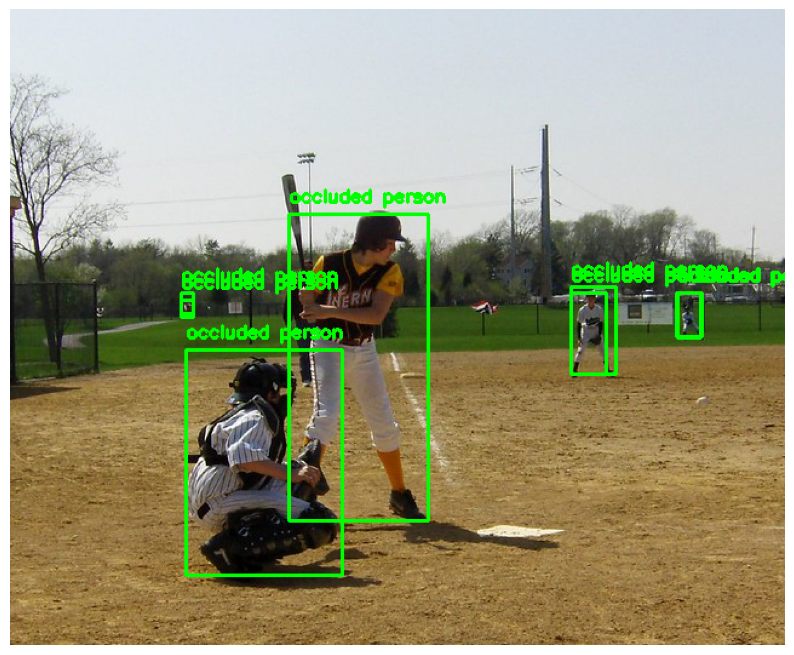

In [22]:
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import GenerationConfig
import requests
from io import BytesIO
import re
import cv2
from matplotlib import pyplot as plt
import numpy as np


cls = "occluded person"
model.threshold = -3.25


url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)
#prompt = f'detect Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'
prompt = f'detect Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'

model_inputs = processor(images=image, text=prompt, return_tensors="pt")
model_inputs = {k: v.to(model.device) if torch.is_tensor(v) else v for k, v in model_inputs.items()}
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

answer = decoded
bounding_boxes = []
pattern = r"<loc(\d+)>"
string_list = re.findall(pattern, answer)

# Assuming string_list is already defined and populated
boxes = []

# Iterate over string_list in steps of 4
for i in range(0, len(string_list), 4):
    # Slice out a chunk of 4 elements and append it to groups
    box = string_list[i:i+4]
    box = [int(x) for x in box]
    if len(box)==4:
        boxes.append(box)
#print(f'answer: {answer}, string list: {boxes}')  # debug

for box in boxes:
    y0, x0, y1, x1 = box
    left = x0/1024
    top = y0/1024
    right = x1/1024
    bottom = y1/1024
    bounding_boxes.append([left, top, right, bottom])
    
    print(bounding_boxes)

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
